In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [4]:
df = pd.read_csv(path+"/IMDB Dataset.csv")
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64
sentiment
1    25000
0    25000
Name: count, dtype: int64


<Axes: >

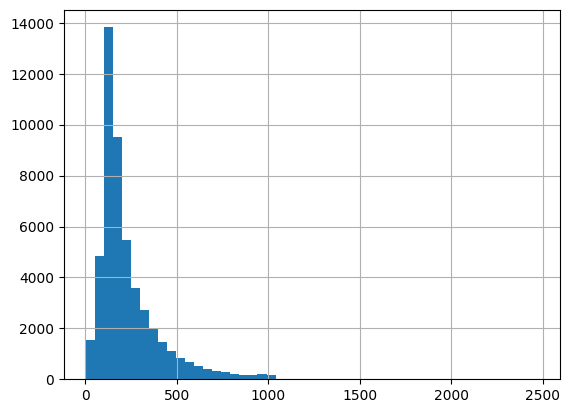

In [5]:
print(df['review'].apply(len).describe())
print(df['sentiment'].value_counts())
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['word_count'].hist(bins=50)


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    tokens = text.split()
    tokens = [w for w in tokens if w not in ENGLISH_STOP_WORDS]
    return tokens

df['tokens'] = df['review'].apply(clean_text)


In [7]:
def vector_average(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean([model[token] for token in valid_tokens], axis=0)


In [8]:
w2v_model = api.load("word2vec-google-news-300")
X = np.array([vector_average(tokens, w2v_model, 300) for tokens in tqdm(df['tokens'])])
y = df['sentiment'].values

[==================================================] 100.0% 1662.8/1662.8MB downloaded


100%|██████████| 50000/50000 [00:27<00:00, 1814.33it/s]


In [9]:
skip_model = gensim.models.Word2Vec(df['tokens'], vector_size=100, window=5, sg=1, epochs=10)
X_skip = np.array([vector_average(tokens, skip_model.wv, 100) for tokens in tqdm(df['tokens'])])


100%|██████████| 50000/50000 [00:13<00:00, 3626.67it/s]


In [11]:
cbow_model = gensim.models.Word2Vec(df['tokens'], vector_size=100, window=5, sg=0, epochs=10)
X_cbow = np.array([vector_average(tokens, cbow_model.wv, 100) for tokens in tqdm(df['tokens'])])


100%|██████████| 50000/50000 [00:11<00:00, 4187.29it/s]


In [12]:
fasttext_model = gensim.models.FastText(df['tokens'], vector_size=100, window=5, epochs=10)
X_fast = np.array([vector_average(tokens, fasttext_model.wv, 100) for tokens in tqdm(df['tokens'])])


100%|██████████| 50000/50000 [00:25<00:00, 1931.66it/s]


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return {'precision': precision, 'recall': recall, 'f1': f1}


In [14]:
results = {
    "Pretrained W2V": evaluate(X, y),
    "Custom Skip-gram": evaluate(X_skip, y),
    "Custom CBOW": evaluate(X_cbow, y),
    "Custom FastText": evaluate(X_fast, y)
}

In [15]:
performance_df = pd.DataFrame(results).T
performance_df = performance_df[['precision', 'recall', 'f1']]
performance_df = performance_df.round(4)
performance_df

,precision,recall,f1
Pretrained W2V,0.8450,0.8450,0.8450
Custom Skip-gram,0.8761,0.8761,0.8761
Custom CBOW,0.8683,0.8682,0.8682
Custom FastText,0.8573,0.8572,0.8572
